In [1]:
import numpy as np
import cv2
import albumentations as A
from utils import plot_examples
from PIL import Image

In [2]:
DATA_DIR = '../dataset/albumentation'

In [3]:
image = Image.open(f"{DATA_DIR}/images/elon.jpeg")

In [4]:
# transforms using the albumentation library
transform = A.Compose([
    A.Resize(width=1920, height=1080),
    A.RandomCrop(width=1280, height=720),
    A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
    A.OneOf([
        A.Blur(blur_limit=3, p=0.5),
        A.ColorJitter(p=0.5),
    ], p = 0.5)
])

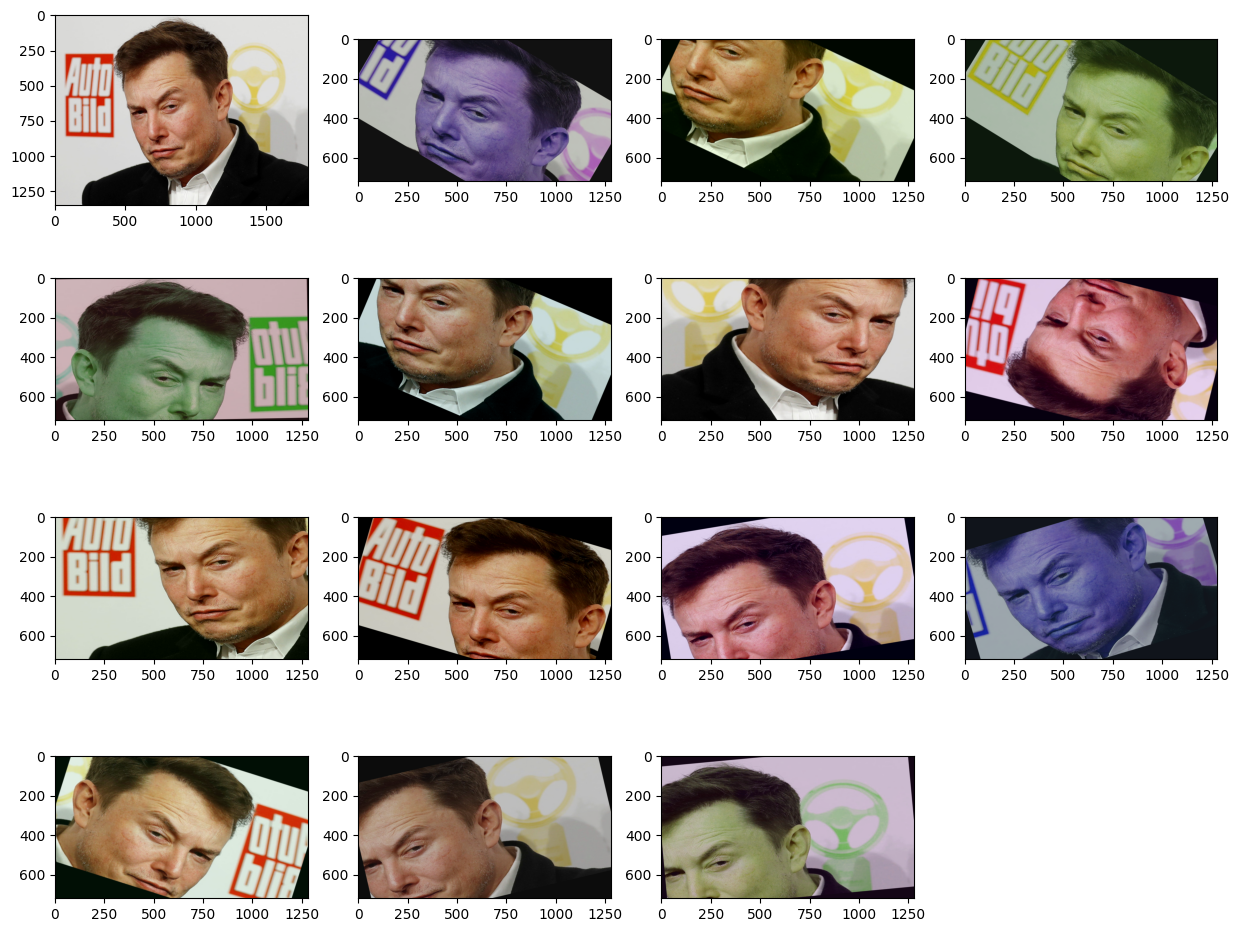

In [5]:
images_list = [image]
image = np.array(image)
for i in range(15):
    augmentations = transform(image=image)
    augmented_image = augmentations['image']
    images_list.append(augmented_image)
    
plot_examples(images_list)

# segmentation

In [6]:
image = Image.open(f"{DATA_DIR}/images/elon.jpeg")
mask = Image.open(f"{DATA_DIR}/images/mask.jpeg")

In [7]:
# transforms using the albumentation library
transform = A.Compose([
    A.Resize(width=1920, height=1080),
    A.RandomCrop(width=1280, height=720),
    A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
    A.OneOf([
        A.Blur(blur_limit=3, p=0.5),
        A.ColorJitter(p=0.5),
    ], p = 0.5)
])

In [8]:
images_list = [image]
image = np.array(image)
mask = np.array(mask) # np.asarray(mask), np.array(mask)
mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
for i in range(10):
    augmentations = transform(image=image, mask=mask)
    augmented_image = augmentations['image']
    augmented_mask = augmentations['mask']
    images_list.append(augmented_image)
    images_list.append(augmented_mask)
    


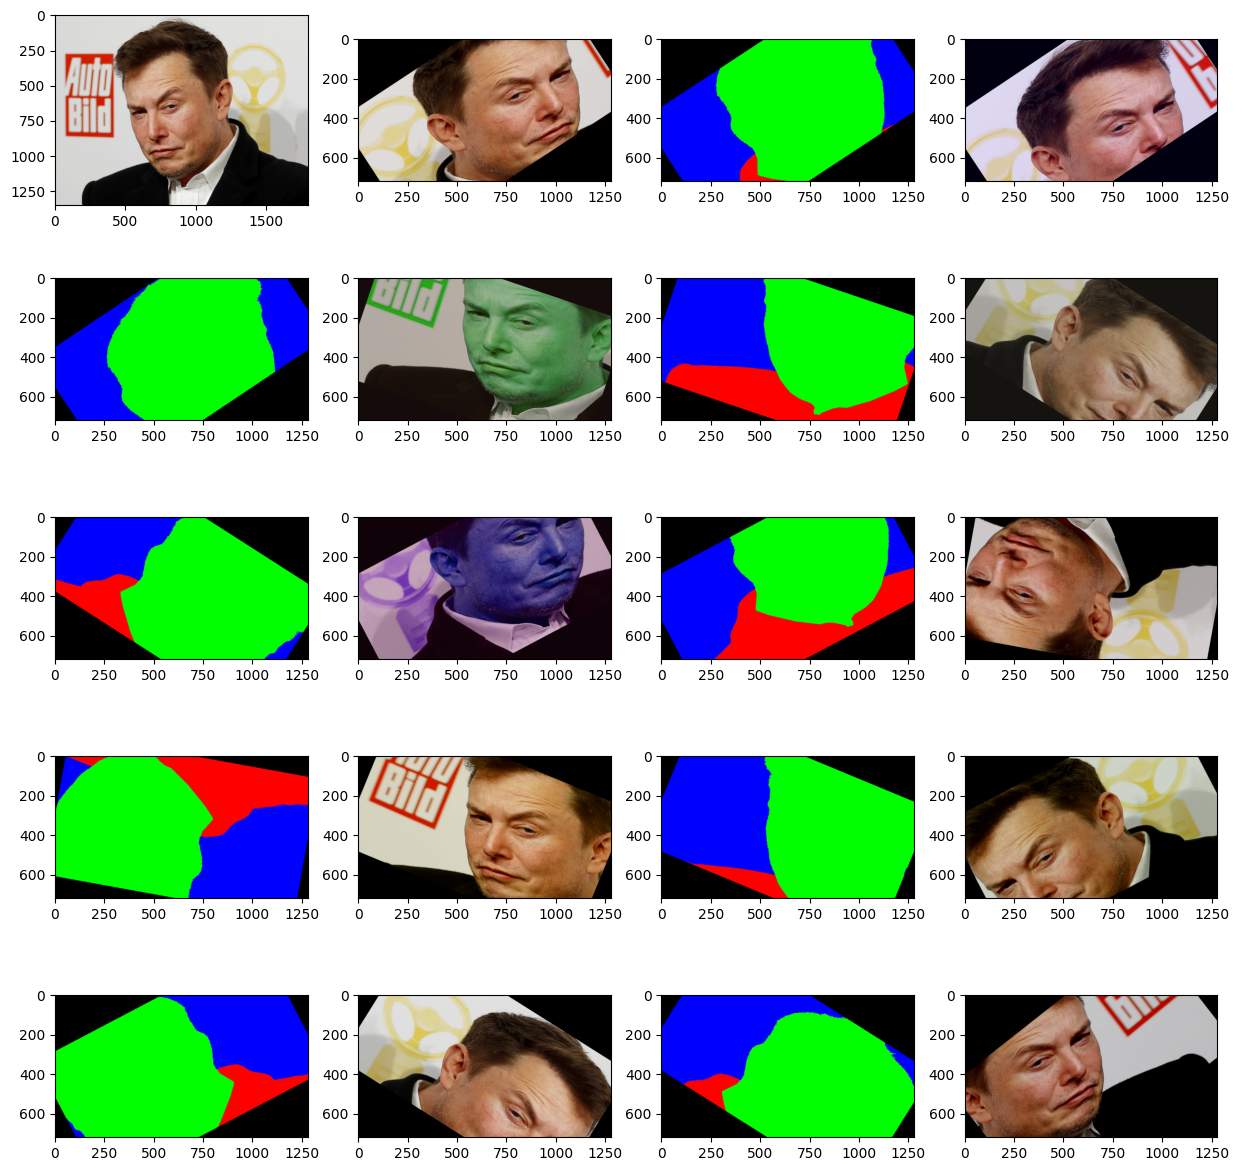

In [9]:
plot_examples(images_list)

# Detection

In [16]:
image = cv2.imread(r"../dataset/albumentation/images/cat.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [17]:
# bounding boxes
bboxes = [[13, 170, 224, 410]]
# pascal voc (x_min, y_min, x_max, y_max)
# yolo (x_center, y_center, width, height)
# coco (x_min, y_min, width, height)

In [23]:
# transforms using the albumentation library
transform = A.Compose(
    [
        A.Resize(width=1920, height=1080),
        A.RandomCrop(width=1280, height=720),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ], p = 0.5)
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', 
        label_fields=[],
        min_area=2048,
        min_visibility=0.5,
    )
)

In [24]:
images_list = [image]
saved_bboxes = [bboxes[0]]
for i in range(10):
    augmentations = transform(image=image, bboxes=bboxes)
    augmented_image = augmentations['image']
    if len(augmentations['bboxes']) == 0:
        continue

    images_list.append(augmented_image)
    saved_bboxes.append(augmentations['bboxes'][0])
    


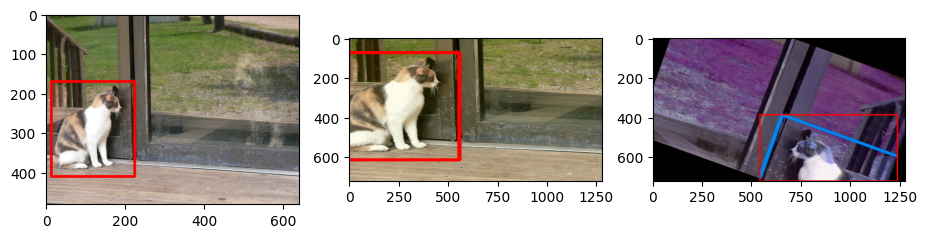

In [25]:
plot_examples(images_list, saved_bboxes)

# Full Example

In [26]:
import torch
import numpy as np
import cv2 
from PIL import Image
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

In [27]:
# dataset
class ImageFolder(nn.Module):
    def __init__(self, root_dir, transform=None) -> None:
        super(ImageFolder, self).__init__()
        self.data = []
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = os.listdir(root_dir)

        for index, name in enumerate(self.class_names):
            files = os.listdir(os.path.join(root_dir, name))
            self.data += list(zip(files, [index]*len(files)))
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_file, label = self.data[index]
        root_and_dir = os.path.join(self.root_dir, self.class_names[label])
        image = np.array(Image.open(os.path.join(root_and_dir, img_file)))
        
        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations['image']
            
        return image, label

In [28]:
# transforms using the albumentation library
transform = A.Compose(
        [
        A.Resize(width=1920, height=1080),
        A.RandomCrop(width=1280, height=720),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ], p = 1.0),
        # ToTensor -> Normalize(mean, std)
        A.Normalize(
            mean=[0, 0, 0],
            std=[1, 1, 1],
            max_pixel_value=255,
        ),
        ToTensorV2()
    ]
)

In [30]:
dataset = ImageFolder(root_dir="../dataset/albumentation/cat_dogs", transform=transform)

for x, y in dataset:
    print(x.shape)
    break

torch.Size([3, 720, 1280])


# ...continue with DataLoader and Model creation